# Training Notebook for VQ-VAE
To be run using on the Google Colab servers

### Global setup

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Connect to Github repository and import code

In [20]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!git clone --branch DMOL --single-branch https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 253 (delta 32), reused 54 (delta 17), pack-reused 179 (from 1)
Receiving objects: 100% (253/253), 187.94 MiB | 39.35 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Updating files: 100% (8/8), done.


In [21]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin DMOL

# refrsh the imports
from importlib import reload
import VQ.model
reload(VQ.model)

from VQ.model import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS

/content/VQ-VAE-Tranformer-Image-Gen
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 336 bytes | 336.00 KiB/s, done.
From https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen
 * branch            DMOL       -> FETCH_HEAD
   ceecfdb..b6466ec  DMOL       -> origin/DMOL
Updating ceecfdb..b6466ec
Fast-forward
 VQ/model.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


### Load CelebA dataset

Dataset URL: https://www.kaggle.com/datasets/zuozhaorui/celeba
License(s): unknown
 98% 2.59G/2.64G [00:01<00:00, 994MB/s] 
100% 2.64G/2.64G [00:02<00:00, 1.40GB/s]


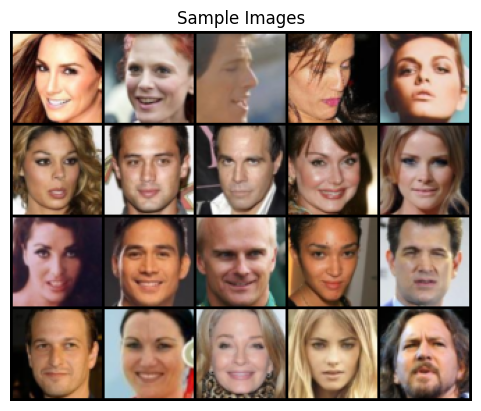

In [5]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from kaggle
!kaggle datasets download -d zuozhaorui/celeba
!mkdir ./data
!unzip -q celeba.zip -d ./data/celeba

# load dataset using ImageFolder dataset
class CelebATransform:
    '''
    Crops around the face and resizes to IMG_HxIMG_W
    '''
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (IMG_H, IMG_W))
        return img

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.base = torchvision.datasets.ImageFolder(root=root, transform=CelebATransform())

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base.__getitem__(idx)
        target = torch.from_numpy(np.array(img)).permute(2, 0, 1).long()
        input = target.float() / 255.0
        return input, target

celeba = CelebADataset(root='./data/celeba')

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x)
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Train model

09:32:44 Begin Training
09:33:07 TRAINING Step [100/23745]; Loss: 27.0418; Commitment: 4.3669; Usage (min/med/max/dead): 0.37, 0.37, 167.55, 0%
09:33:30 TRAINING Step [200/23745]; Loss: 16.9083; Commitment: 0.9606; Usage (min/med/max/dead): 0.13, 0.13, 150.12, 0%
09:33:53 TRAINING Step [300/23745]; Loss: 16.0412; Commitment: 1.2544; Usage (min/med/max/dead): 0.05, 0.05, 92.41, 0%
09:34:16 TRAINING Step [400/23745]; Loss: 15.5897; Commitment: 1.1635; Usage (min/med/max/dead): 0.02, 0.02, 71.86, 0%
09:34:39 TRAINING Step [500/23745]; Loss: 15.5439; Commitment: 1.3675; Usage (min/med/max/dead): 0.01, 0.01, 44.09, 95%
09:35:02 TRAINING Step [600/23745]; Loss: 14.9852; Commitment: 1.1738; Usage (min/med/max/dead): 0.00, 0.00, 44.01, 93%
09:35:25 TRAINING Step [700/23745]; Loss: 15.1802; Commitment: 1.4946; Usage (min/med/max/dead): 0.00, 0.00, 39.71, 92%
09:35:48 TRAINING Step [800/23745]; Loss: 14.9786; Commitment: 1.4977; Usage (min/med/max/dead): 0.00, 0.00, 31.56, 89%
09:36:11 TRAINING 

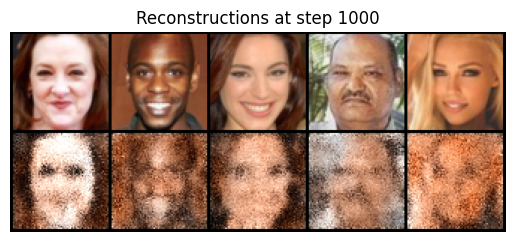

09:36:58 TRAINING Step [1100/23745]; Loss: 14.3763; Commitment: 1.7704; Usage (min/med/max/dead): 0.00, 0.00, 25.85, 83%
09:37:21 TRAINING Step [1200/23745]; Loss: 14.4403; Commitment: 1.7440; Usage (min/med/max/dead): 0.00, 0.00, 26.09, 79%
09:37:44 TRAINING Step [1300/23745]; Loss: 14.0953; Commitment: 1.6616; Usage (min/med/max/dead): 0.00, 0.00, 24.85, 77%
09:38:07 TRAINING Step [1400/23745]; Loss: 14.0067; Commitment: 1.7572; Usage (min/med/max/dead): 0.00, 0.00, 23.33, 75%
09:38:30 TRAINING Step [1500/23745]; Loss: 13.9247; Commitment: 1.7381; Usage (min/med/max/dead): 0.00, 0.00, 19.78, 70%
Checkpoint saved at step 1583 to /content/drive/MyDrive/vq_models/checkpoint.pt


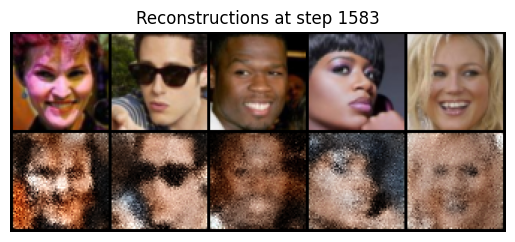

09:38:55 TRAINING Step [1600/23745]; Loss: 13.8013; Commitment: 1.7072; Usage (min/med/max/dead): 0.00, 0.00, 17.10, 66%
09:39:18 TRAINING Step [1700/23745]; Loss: 13.7060; Commitment: 1.6824; Usage (min/med/max/dead): 0.00, 0.00, 15.76, 63%
09:39:41 TRAINING Step [1800/23745]; Loss: 13.6208; Commitment: 1.6631; Usage (min/med/max/dead): 0.00, 0.00, 14.69, 62%
09:40:04 TRAINING Step [1900/23745]; Loss: 13.5718; Commitment: 1.6763; Usage (min/med/max/dead): 0.00, 0.00, 14.15, 58%
09:40:27 TRAINING Step [2000/23745]; Loss: 13.5530; Commitment: 1.7044; Usage (min/med/max/dead): 0.00, 0.00, 14.03, 54%
Checkpoint saved at step 2000 to /content/drive/MyDrive/vq_models/checkpoint.pt


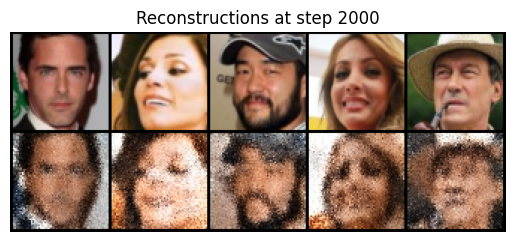

09:40:51 TRAINING Step [2100/23745]; Loss: 13.5611; Commitment: 1.7308; Usage (min/med/max/dead): 0.00, 0.06, 13.29, 48%
09:41:14 TRAINING Step [2200/23745]; Loss: 13.6508; Commitment: 1.8481; Usage (min/med/max/dead): 0.00, 0.43, 12.24, 35%
09:41:37 TRAINING Step [2300/23745]; Loss: 13.8334; Commitment: 2.0302; Usage (min/med/max/dead): 0.00, 0.58, 11.22, 15%
09:42:01 TRAINING Step [2400/23745]; Loss: 14.0356; Commitment: 2.3168; Usage (min/med/max/dead): 0.01, 0.63, 10.57, 0%
09:42:24 TRAINING Step [2500/23745]; Loss: 13.9826; Commitment: 2.3437; Usage (min/med/max/dead): 0.03, 0.64, 10.50, 0%
09:42:47 TRAINING Step [2600/23745]; Loss: 14.0456; Commitment: 2.4633; Usage (min/med/max/dead): 0.06, 0.68, 10.16, 0%
09:43:10 TRAINING Step [2700/23745]; Loss: 14.0422; Commitment: 2.4587; Usage (min/med/max/dead): 0.08, 0.71, 9.79, 0%
09:43:33 TRAINING Step [2800/23745]; Loss: 14.0890; Commitment: 2.5236; Usage (min/med/max/dead): 0.11, 0.73, 9.77, 0%
09:43:56 TRAINING Step [2900/23745]; Lo

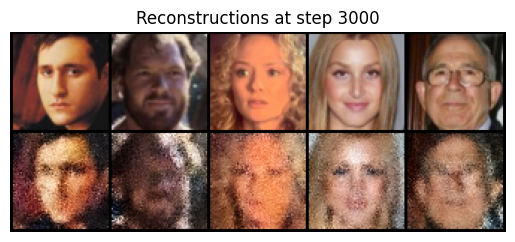

09:44:43 TRAINING Step [3100/23745]; Loss: 14.2234; Commitment: 2.7250; Usage (min/med/max/dead): 0.30, 0.79, 9.52, 0%
Checkpoint saved at step 3166 to /content/drive/MyDrive/vq_models/checkpoint.pt


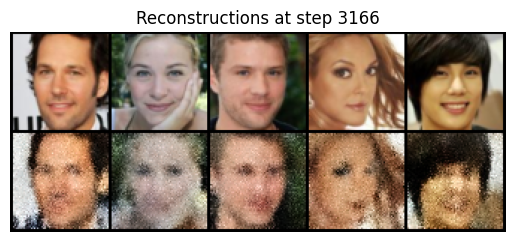

09:45:08 TRAINING Step [3200/23745]; Loss: 14.2293; Commitment: 2.7358; Usage (min/med/max/dead): 0.31, 0.79, 9.26, 0%
09:45:31 TRAINING Step [3300/23745]; Loss: 14.2935; Commitment: 2.7909; Usage (min/med/max/dead): 0.30, 0.80, 8.66, 0%
09:45:54 TRAINING Step [3400/23745]; Loss: 14.3123; Commitment: 2.8475; Usage (min/med/max/dead): 0.30, 0.82, 8.73, 0%
09:46:17 TRAINING Step [3500/23745]; Loss: 14.3776; Commitment: 2.9289; Usage (min/med/max/dead): 0.30, 0.82, 8.64, 0%
09:46:40 TRAINING Step [3600/23745]; Loss: 14.4002; Commitment: 2.9514; Usage (min/med/max/dead): 0.30, 0.82, 8.42, 0%
09:47:03 TRAINING Step [3700/23745]; Loss: 14.4144; Commitment: 2.9789; Usage (min/med/max/dead): 0.30, 0.84, 8.17, 0%
09:47:26 TRAINING Step [3800/23745]; Loss: 14.4642; Commitment: 3.0284; Usage (min/med/max/dead): 0.30, 0.84, 7.79, 0%
09:47:49 TRAINING Step [3900/23745]; Loss: 14.4386; Commitment: 3.0224; Usage (min/med/max/dead): 0.30, 0.85, 7.51, 0%
09:48:12 TRAINING Step [4000/23745]; Loss: 14.46

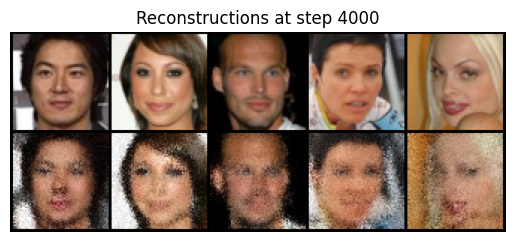

09:48:36 TRAINING Step [4100/23745]; Loss: 14.5147; Commitment: 3.1048; Usage (min/med/max/dead): 0.28, 0.86, 7.49, 0%
09:48:59 TRAINING Step [4200/23745]; Loss: 14.5094; Commitment: 3.0807; Usage (min/med/max/dead): 0.27, 0.87, 7.00, 0%
09:49:22 TRAINING Step [4300/23745]; Loss: 14.5609; Commitment: 3.1824; Usage (min/med/max/dead): 0.26, 0.87, 7.13, 0%
09:49:45 TRAINING Step [4400/23745]; Loss: 14.5764; Commitment: 3.1855; Usage (min/med/max/dead): 0.25, 0.88, 7.07, 0%
09:50:08 TRAINING Step [4500/23745]; Loss: 14.5669; Commitment: 3.1699; Usage (min/med/max/dead): 0.24, 0.88, 6.88, 0%
09:50:31 TRAINING Step [4600/23745]; Loss: 14.5901; Commitment: 3.2055; Usage (min/med/max/dead): 0.23, 0.90, 6.81, 0%
09:50:54 TRAINING Step [4700/23745]; Loss: 14.6139; Commitment: 3.2348; Usage (min/med/max/dead): 0.23, 0.90, 6.85, 0%
Checkpoint saved at step 4749 to /content/drive/MyDrive/vq_models/checkpoint.pt


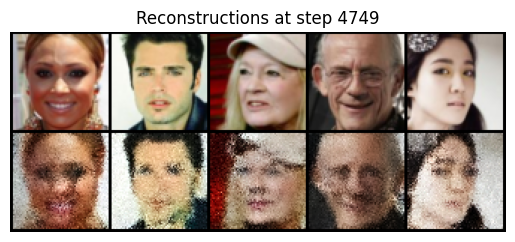

09:51:19 TRAINING Step [4800/23745]; Loss: 14.5802; Commitment: 3.2131; Usage (min/med/max/dead): 0.24, 0.90, 6.77, 0%
09:51:42 TRAINING Step [4900/23745]; Loss: 14.6558; Commitment: 3.2944; Usage (min/med/max/dead): 0.25, 0.91, 6.74, 0%
09:52:05 TRAINING Step [5000/23745]; Loss: 14.6817; Commitment: 3.3304; Usage (min/med/max/dead): 0.24, 0.90, 6.60, 0%
Checkpoint saved at step 5000 to /content/drive/MyDrive/vq_models/checkpoint.pt


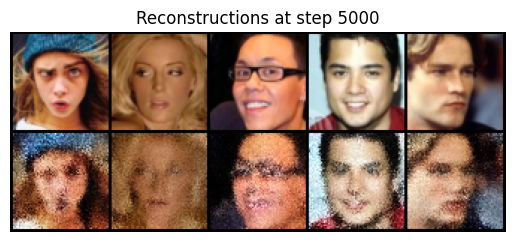

09:52:29 TRAINING Step [5100/23745]; Loss: 14.6844; Commitment: 3.3149; Usage (min/med/max/dead): 0.23, 0.91, 6.50, 0%
09:52:52 TRAINING Step [5200/23745]; Loss: 14.6616; Commitment: 3.3249; Usage (min/med/max/dead): 0.23, 0.91, 6.39, 0%
09:53:15 TRAINING Step [5300/23745]; Loss: 14.6892; Commitment: 3.3452; Usage (min/med/max/dead): 0.21, 0.92, 6.32, 0%
09:53:38 TRAINING Step [5400/23745]; Loss: 14.6587; Commitment: 3.3204; Usage (min/med/max/dead): 0.23, 0.92, 6.33, 0%
09:54:01 TRAINING Step [5500/23745]; Loss: 14.6846; Commitment: 3.3385; Usage (min/med/max/dead): 0.22, 0.92, 6.22, 0%
09:54:24 TRAINING Step [5600/23745]; Loss: 14.7562; Commitment: 3.4385; Usage (min/med/max/dead): 0.23, 0.93, 6.27, 0%
09:54:47 TRAINING Step [5700/23745]; Loss: 14.7356; Commitment: 3.4036; Usage (min/med/max/dead): 0.23, 0.92, 6.07, 0%
09:55:10 TRAINING Step [5800/23745]; Loss: 14.7437; Commitment: 3.4195; Usage (min/med/max/dead): 0.24, 0.92, 5.98, 0%
09:55:33 TRAINING Step [5900/23745]; Loss: 14.73

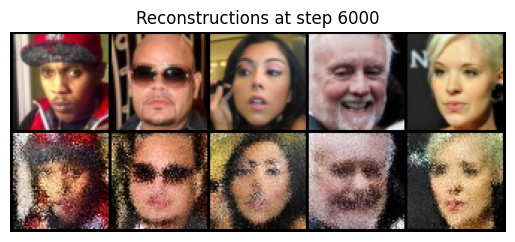

09:56:21 TRAINING Step [6100/23745]; Loss: 14.7427; Commitment: 3.4374; Usage (min/med/max/dead): 0.26, 0.92, 5.97, 0%
09:56:44 TRAINING Step [6200/23745]; Loss: 14.7496; Commitment: 3.4591; Usage (min/med/max/dead): 0.24, 0.93, 5.81, 0%
09:57:07 TRAINING Step [6300/23745]; Loss: 14.7686; Commitment: 3.4770; Usage (min/med/max/dead): 0.25, 0.93, 5.79, 0%
Checkpoint saved at step 6332 to /content/drive/MyDrive/vq_models/checkpoint.pt


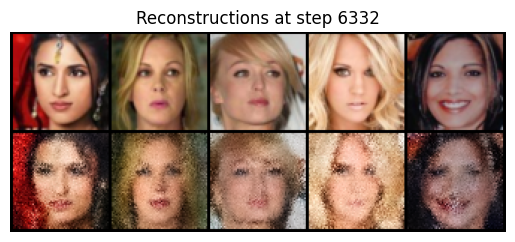

09:57:31 TRAINING Step [6400/23745]; Loss: 14.7647; Commitment: 3.4666; Usage (min/med/max/dead): 0.23, 0.93, 5.79, 0%
09:57:54 TRAINING Step [6500/23745]; Loss: 14.7615; Commitment: 3.4767; Usage (min/med/max/dead): 0.23, 0.94, 5.76, 0%
09:58:17 TRAINING Step [6600/23745]; Loss: 14.7503; Commitment: 3.4680; Usage (min/med/max/dead): 0.25, 0.95, 5.74, 0%
09:58:40 TRAINING Step [6700/23745]; Loss: 14.7503; Commitment: 3.4554; Usage (min/med/max/dead): 0.23, 0.95, 5.48, 0%
09:59:03 TRAINING Step [6800/23745]; Loss: 14.7340; Commitment: 3.4594; Usage (min/med/max/dead): 0.23, 0.96, 5.65, 0%
09:59:26 TRAINING Step [6900/23745]; Loss: 14.7934; Commitment: 3.5320; Usage (min/med/max/dead): 0.22, 0.96, 5.61, 0%
09:59:49 TRAINING Step [7000/23745]; Loss: 14.8017; Commitment: 3.5457; Usage (min/med/max/dead): 0.21, 0.96, 5.62, 0%
Checkpoint saved at step 7000 to /content/drive/MyDrive/vq_models/checkpoint.pt


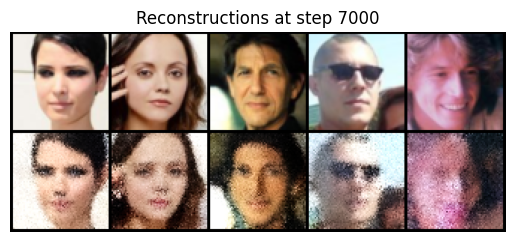

10:00:14 TRAINING Step [7100/23745]; Loss: 14.8292; Commitment: 3.5659; Usage (min/med/max/dead): 0.24, 0.95, 5.72, 0%
10:00:37 TRAINING Step [7200/23745]; Loss: 14.7458; Commitment: 3.4880; Usage (min/med/max/dead): 0.26, 0.95, 5.76, 0%
10:01:00 TRAINING Step [7300/23745]; Loss: 14.7625; Commitment: 3.5229; Usage (min/med/max/dead): 0.25, 0.96, 5.65, 0%
10:01:23 TRAINING Step [7400/23745]; Loss: 14.7919; Commitment: 3.5583; Usage (min/med/max/dead): 0.24, 0.95, 5.82, 0%
10:01:46 TRAINING Step [7500/23745]; Loss: 14.7857; Commitment: 3.5472; Usage (min/med/max/dead): 0.22, 0.95, 5.76, 0%
10:02:09 TRAINING Step [7600/23745]; Loss: 14.7973; Commitment: 3.5269; Usage (min/med/max/dead): 0.20, 0.95, 5.43, 0%
10:02:32 TRAINING Step [7700/23745]; Loss: 14.7242; Commitment: 3.4715; Usage (min/med/max/dead): 0.19, 0.95, 5.54, 0%
10:02:55 TRAINING Step [7800/23745]; Loss: 14.6837; Commitment: 3.4046; Usage (min/med/max/dead): 0.20, 0.95, 5.43, 0%
10:03:18 TRAINING Step [7900/23745]; Loss: 14.76

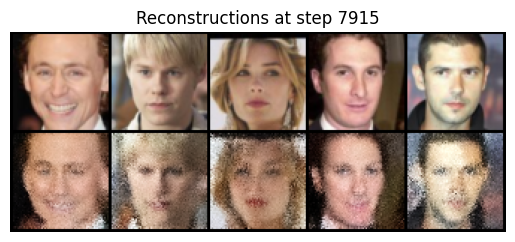

10:03:43 TRAINING Step [8000/23745]; Loss: 14.7986; Commitment: 3.5945; Usage (min/med/max/dead): 0.23, 0.95, 5.63, 0%
Checkpoint saved at step 8000 to /content/drive/MyDrive/vq_models/checkpoint.pt


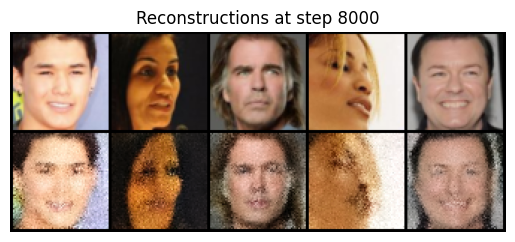

10:04:07 TRAINING Step [8100/23745]; Loss: 14.7969; Commitment: 3.5331; Usage (min/med/max/dead): 0.20, 0.95, 5.27, 0%
10:04:30 TRAINING Step [8200/23745]; Loss: 14.7403; Commitment: 3.5237; Usage (min/med/max/dead): 0.21, 0.95, 5.61, 0%
10:04:53 TRAINING Step [8300/23745]; Loss: 14.7793; Commitment: 3.5812; Usage (min/med/max/dead): 0.21, 0.95, 5.52, 0%
10:05:16 TRAINING Step [8400/23745]; Loss: 14.7782; Commitment: 3.5791; Usage (min/med/max/dead): 0.20, 0.95, 5.56, 0%
10:05:39 TRAINING Step [8500/23745]; Loss: 14.7909; Commitment: 3.5793; Usage (min/med/max/dead): 0.18, 0.96, 5.43, 0%
10:06:02 TRAINING Step [8600/23745]; Loss: 14.7641; Commitment: 3.5695; Usage (min/med/max/dead): 0.23, 0.96, 5.45, 0%
10:06:25 TRAINING Step [8700/23745]; Loss: 14.7633; Commitment: 3.5523; Usage (min/med/max/dead): 0.23, 0.95, 5.40, 0%
10:06:48 TRAINING Step [8800/23745]; Loss: 14.8099; Commitment: 3.6224; Usage (min/med/max/dead): 0.20, 0.95, 5.30, 0%
10:07:11 TRAINING Step [8900/23745]; Loss: 14.76

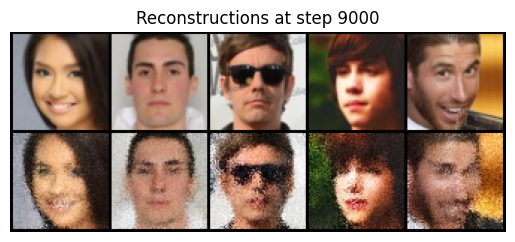

10:07:58 TRAINING Step [9100/23745]; Loss: 14.7776; Commitment: 3.6088; Usage (min/med/max/dead): 0.21, 0.94, 5.12, 0%
10:08:21 TRAINING Step [9200/23745]; Loss: 14.7724; Commitment: 3.5998; Usage (min/med/max/dead): 0.21, 0.95, 5.08, 0%
10:08:44 TRAINING Step [9300/23745]; Loss: 14.7726; Commitment: 3.5801; Usage (min/med/max/dead): 0.20, 0.94, 4.96, 0%
10:09:07 TRAINING Step [9400/23745]; Loss: 14.8201; Commitment: 3.6603; Usage (min/med/max/dead): 0.21, 0.94, 4.81, 0%
Checkpoint saved at step 9498 to /content/drive/MyDrive/vq_models/checkpoint.pt


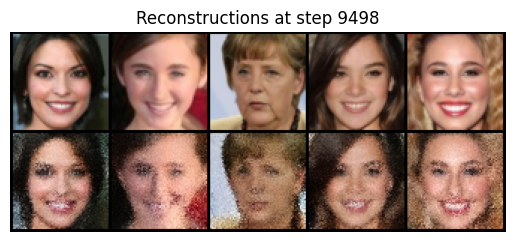

10:09:32 TRAINING Step [9500/23745]; Loss: 14.7910; Commitment: 3.6467; Usage (min/med/max/dead): 0.20, 0.94, 4.87, 0%
10:09:55 TRAINING Step [9600/23745]; Loss: 14.7399; Commitment: 3.5789; Usage (min/med/max/dead): 0.19, 0.94, 4.85, 0%
10:10:18 TRAINING Step [9700/23745]; Loss: 14.7699; Commitment: 3.6227; Usage (min/med/max/dead): 0.21, 0.95, 4.92, 0%
10:10:41 TRAINING Step [9800/23745]; Loss: 14.7817; Commitment: 3.6272; Usage (min/med/max/dead): 0.19, 0.95, 4.80, 0%
10:11:04 TRAINING Step [9900/23745]; Loss: 14.7440; Commitment: 3.5561; Usage (min/med/max/dead): 0.18, 0.94, 4.80, 0%
10:11:27 TRAINING Step [10000/23745]; Loss: 14.6895; Commitment: 3.5491; Usage (min/med/max/dead): 0.21, 0.94, 4.94, 0%
Checkpoint saved at step 10000 to /content/drive/MyDrive/vq_models/checkpoint.pt


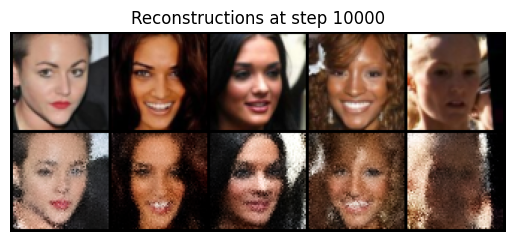

10:11:51 TRAINING Step [10100/23745]; Loss: 14.7524; Commitment: 3.6250; Usage (min/med/max/dead): 0.22, 0.93, 5.03, 0%


KeyboardInterrupt: 

In [23]:
from time import strftime

# Initialize and train a model. If you just want to load one from a checkpoint and not train, set EPOCHS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training hyperparemeters
EPOCHS = 15
BATCH_SIZE = 256
BETA = 0.25
GRAD_CLIP = None

# logging/saving hyperparemters
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
CHECKPOINT_DIR = '/content/drive/MyDrive/vq_models'
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'checkpoint.pt')
LOAD_FROM_CHECKPOINT = False

dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True, batch_size=BATCH_SIZE)
model = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

training_losses = []
training_steps = 0
running_losses = [0.0, 0.0, 0.0]

# load from checkpoint
if LOAD_FROM_CHECKPOINT:
    if not os.path.exists(CHECKPOINT_PATH):
        print(f'WARNING: Checkpoint not found at {CHECKPOINT_PATH}!')
    else:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        training_steps = checkpoint['training_steps']
        training_losses = checkpoint['training_losses']
        running_losses = checkpoint['running_losses']

        print(f'Checkpoint loaded. Resuming from training step {training_steps}.')

total_steps = training_steps + len(dataloader) * EPOCHS

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
model.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        input, target = batch
        input = input.to(device)
        target = target.to(device)

        reconstruction_loss, commitment_loss, codebook_loss = model(input, target)
        if model.use_EMA:
            loss = reconstruction_loss + BETA * commitment_loss + codebook_loss
        else:
            loss = reconstruction_loss + BETA * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        if GRAD_CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
        optimizer.step()
        training_steps += 1

        running_losses[0] += loss.item()
        running_losses[1] += reconstruction_loss.item()
        running_losses[2] += commitment_loss.item()

        # logging step
        if training_steps % LOG_INTERVAL == 0:
            avg_losses = [loss / LOG_INTERVAL for loss in running_losses]
            running_losses = [0.0, 0.0, 0.0]
            training_losses.append((training_steps, avg_losses))
            with torch.no_grad():
                p = model.quantizer.N / model.quantizer.N.sum() * 512
                print(f'{strftime('%H:%M:%S')} TRAINING Step [{training_steps}/{total_steps}]; Loss: {avg_losses[0]:.4f}; Commitment: {avg_losses[2]:.4f}; Usage (min/med/max/dead): {p.min().item():.2f}, {p.median().item():.2f}, {p.max().item():.2f}, {torch.sum(p < 0.01) / 512 * 100:.0f}%')

        # saving step
        if training_steps % SAVE_INTERVAL == 0 or batch_idx == len(dataloader) - 1:
            checkpoint = {
                'training_steps': training_steps,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'training_losses': training_losses,
                'running_losses': running_losses,
            }

            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f'Checkpoint saved at step {training_steps} to {CHECKPOINT_PATH}')

            # visualize reconstructions
            grid_x = 5
            grid_y = 2

            input, target = next(iter(dataloader))
            input = input[:grid_x * grid_y // 2].to(device)
            target = target[:grid_x * grid_y // 2].to(device)

            model.eval()
            params = model.reconstruct(input)
            reconstructed = model.decoder.sample_from_params(params)
            model.train()

            images = torch.cat((target, reconstructed), dim=0)
            img = torchvision.utils.make_grid(images.float() / 255.0, grid_x)

            plt.title(f'Reconstructions at step {training_steps}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

# Prepare loss data
steps_list = [item[0] for item in training_losses]
avg_losses_list = [item[1] for item in training_losses]

steps = np.array(steps_list)
losses = np.array(avg_losses_list)   # shape: (num_steps, 3)

# Prepare reconstructions
grid_x = 5
grid_y = 4

input, target = next(iter(dataloader))
input = input[:grid_x * grid_y // 2].to(device)
target = target[:grid_x * grid_y // 2].to(device)

model.eval()
params = model.reconstruct(input)
reconstructed = model.decoder.sample_from_params(params)
model.train()

images = torch.cat((target, reconstructed), dim=0)
img = torchvision.utils.make_grid(images.float() / 255.0, grid_x)

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(steps, losses[:, 0], label='Loss')
axes[0].plot(steps, losses[:, 1], label='Reconstruction Loss')
axes[0].plot(steps, losses[:, 2], label='Commitment Loss')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Losses over Training Steps')
axes[0].legend()
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Compute CelebA embeddings

In [ ]:
from tqdm import tqdm

celeba_indices = []

model.eval()
for batch in tqdm(dataloader):
    input, target = batch
    input = input.to(device)
    indices = model.compute_indices(input)
    celeba_indices.append(indices.view(-1, LATENT_W * LATENT_H).cpu())

print('Concatenating...')
celeba_indices = torch.cat(celeba_indices, dim=0)
print('Shape:', celeba_indices.shape)
celeba_indices = celeba_indices.to(torch.uint16)
print('Saving...')
torch.save(celeba_indices, os.path.join(CHECKPOINT_DIR, "celeba_vq_indices_uint16.pt"))

100%|██████████| 1583/1583 [01:33<00:00, 16.96it/s]


Concatenating...
Shape: torch.Size([405198, 64])
Saving...


### Random Image Generation with Uniform Prior

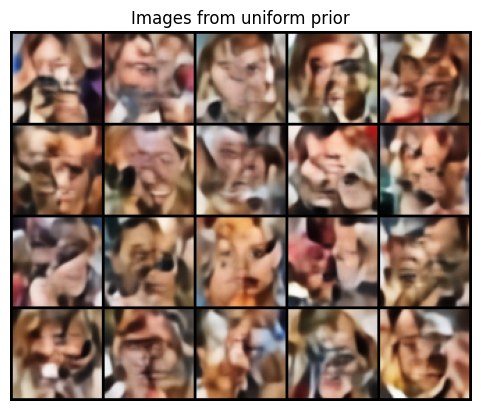

In [ ]:
# visualize
grid_x = 5
grid_y = 4

model.eval()
samples = torch.randint(0, NUM_EMBEDDINGS, (grid_x*grid_y, 8, 8)).to(device)
with torch.no_grad():
    embeddings = model.quantizer.get_latent_tensor_from_indices(samples)
    logits = model.decoder(embeddings)
    reconstructed = model.decoder.sample_from_logits(logits)

img = torchvision.utils.make_grid(reconstructed.float() / 255.0, grid_x)
plt.title(f'Images from uniform prior')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())